# Trivia QA

Today, we will play with Trivia QA, a dataset of questions with answers from Wikipedia. This will give us enough to room to build a RAG model for answering questions based on Wikipedia articles. As usual, first step is downloading the datatset.
OBS: We will be using haystack v2. Refer to [Day10v2.ipnb](Dayv2.ipnb).

In [1]:
from datasets import load_dataset
ds = load_dataset("mandarjoshi/trivia_qa", "rc.wikipedia")

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As we saw, the dataset is too big, so we will use just a small subsample of it.

In [2]:
train = ds['train'].shuffle(seed=42).select(range(1000))
valid = ds['validation'].shuffle(seed=42).select(range(200))
test = ds['test'].shuffle(seed=42).select(range(200))

We can join them together in a new HF dataset, which will facilitate any transformation we need to apply.

In [3]:
from datasets import DatasetDict
ds =  DatasetDict({
    'train': train,
    'validation': valid,
    'test': test
})
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 200
    })
    test: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 200
    })
})

All good. Now let us explore the dataste. We will do so in  validation, as this is smaller.

In [4]:
for feature in ds['validation'].features.keys():
    print(f'{feature}:', ds['validation'][feature][123])

question: Who killed Lee harvey Oswald?
question_id: qz_3040
question_source: https://www.quiz-zone.co.uk/
entity_pages: {'doc_source': ['TagMe', 'TagMe'], 'filename': ['Assassination_of_John_F._Kennedy.txt', 'Lee_Harvey_Oswald.txt'], 'title': ['Assassination of John F. Kennedy', 'Lee Harvey Oswald'], 'wiki_context': ['John Fitzgerald Kennedy, the 35th President of the United States, was assassinated at 12:30\xa0p.m. Central Standard Time (18:30 UTC) on Friday, November 22, 1963, in Dealey Plaza, Dallas, Texas. Fatally shot by Lee Harvey Oswald, Kennedy was traveling with his wife, Jacqueline, Texas Governor John Connally, and Connally\'s wife, Nellie, in a presidential motorcade. A ten-month investigation from November 1963 to September 1964 by the Warren Commission concluded that Oswald acted alone in shooting Kennedy, and that Jack Ruby also acted alone when he killed Oswald before he could stand trial.  Kennedy\'s death marked the fourth and latest successful assassination of an Am

We see that most of these are not really important, so we will clean things a little.

In [5]:
def cleaner(batch):
    batch['answer'] = batch['answer']['value'] 
    batch['context'] = batch['entity_pages']['wiki_context']
    batch['title'] = batch['entity_pages']['title']
    return batch

In [6]:
ds = ds.map(cleaner, remove_columns = ['search_results', 
                                      'question_source',
                                      'entity_pages'])
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'question_id', 'answer', 'context', 'title'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['question', 'question_id', 'answer', 'context', 'title'],
        num_rows: 200
    })
    test: Dataset({
        features: ['question', 'question_id', 'answer', 'context', 'title'],
        num_rows: 200
    })
})

Now, let us do some analysis on the documents' lengths.

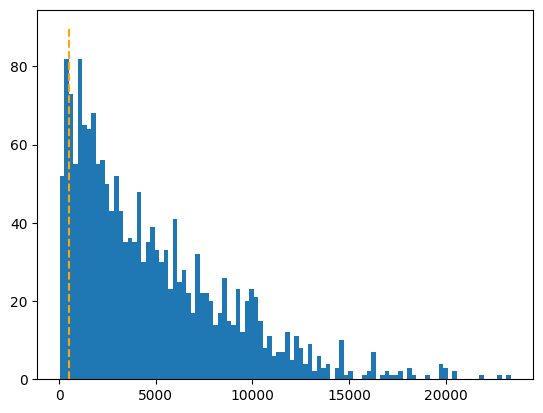

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
words = [len(wiki.split()) for wiki in ds['train'].to_pandas()['context'].explode()]
plt.hist(words, bins = 100)
plt.vlines(512, 0, 90, color = 'orange', linestyles = '--')
plt.show()

As one can see, most texts have length much worse than 512 words, which is a lower bound for tokenization. Most dense models accept at most 512 tokens and even for those witgh no limitation (e.g., BM25), chuncking generally improves indexing. This means that we will need some chunking. Luckily, haystack takes care of chunking for us.

## Document preprocessing

We start by transforming everything into documents. First, we will use pandas to do some cleaning.

In [8]:
import pandas as pd
dfs = {split: dset.to_pandas().explode('context') for split, dset in ds.flatten().items()}

Now we trainsform into haystack documents.

In [9]:
from haystack import Document

docs = []
for split, df in dfs.items():
    # Exclude duplicate reviews
    for _,row in df.drop_duplicates(subset = 'context').iterrows():
        docs.append(Document(content =  row['context'], 
                meta = {'split': split, 'title': row['title']}))

Now we chunck.

In [10]:
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack import Pipeline

pipe = Pipeline()
pipe.add_component(instance = DocumentCleaner(), 
                   name = "cleaner")
pipe.add_component(instance = DocumentSplitter(split_by = "word", 
                                               split_length = 500, # We split at every 500 words
                                               split_overlap = 50), # Havinga an overlap avoids information loss
                                                                  # due to truncation
                                               name = "splitter")
pipe.connect('cleaner.documents', 'splitter.documents')
docs_clean = pipe.run({'cleaner': {'documents': docs}})['splitter']['documents']

Let us give a look.

In [11]:
print(docs_clean[0].content)

The monarchy of the United Kingdom, commonly referred to as the British monarchy, is the constitutional monarchy of the United Kingdom and its overseas territories. The monarch's title is "King" (male) or "Queen" (female). The current monarch and head of state, Queen Elizabeth II, ascended the throne on the death of her father, King George VI, on 6 February 1952. The monarch and his or her immediate family undertake various official, ceremonial, diplomatic and representational duties. As the monarchy is constitutional, the monarch is limited to non-partisan functions such as bestowing honours and appointing the Prime Minister. The monarch is, by tradition, commander-in-chief of the British Armed Forces. Though the ultimate formal executive authority over the government of the United Kingdom is still by and through the monarch's royal prerogative, these powers may only be used according to laws enacted in Parliament and, in practice, within the constraints of convention and precedent. T

In [12]:
print(' '.join(docs[0].content.split()[:501]))

The monarchy of the United Kingdom, commonly referred to as the British monarchy, is the constitutional monarchy of the United Kingdom and its overseas territories. The monarch's title is "King" (male) or "Queen" (female). The current monarch and head of state, Queen Elizabeth II, ascended the throne on the death of her father, King George VI, on 6 February 1952. The monarch and his or her immediate family undertake various official, ceremonial, diplomatic and representational duties. As the monarchy is constitutional, the monarch is limited to non-partisan functions such as bestowing honours and appointing the Prime Minister. The monarch is, by tradition, commander-in-chief of the British Armed Forces. Though the ultimate formal executive authority over the government of the United Kingdom is still by and through the monarch's royal prerogative, these powers may only be used according to laws enacted in Parliament and, in practice, within the constraints of convention and precedent. T

All good, time to save the documents in memory. 

In [13]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
document_store = InMemoryDocumentStore()
document_store.write_documents(documents = docs_clean)
print(f"Loaded {document_store.count_documents()} documents to store")

Loaded 23977 documents to store


For retriever, we shall use BM25 for simplicity.

In [14]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
retriever = InMemoryBM25Retriever(document_store = document_store)

Let us check.

In [15]:
query = ds['train']['question'][0]
print('Question:', query, '\n\nRetrieved @ 5:')
retrieved = retriever.run(query = query, filters =  {"field": "split", "operator": "==", "value": "train"}, top_k = 5)['documents']
for doc in retrieved:
    print(doc.meta['title'])

Question: Who was the oldest British monarch at the time of ascending the throne? 

Retrieved @ 5:
['Monarchy of the United Kingdom']
['Monarchy']
['Bhumibol Adulyadej' 'Monarchy of Thailand' 'Asian Americans']
['Monarchy']
['Monarchy of the United Kingdom']


In [16]:
title = ds['train']['title'][0][0]
title

'Monarchy of the United Kingdom'

So, although most are about "monarchy", several are not relevant to the actual question. We can, in fact, use this to estimate precision@k. 

In [17]:
def precision_at_k(query_idx, split = 'test', k = 5):
    title = ds[split]['title'][query_idx] 
    query = ds[split]['question'][query_idx]
    retrieved = retriever.run(query = query, filters =  {"field": "split", "operator": "==", "value": split}, top_k = k)['documents']
    return [list(doc.meta['title']) for doc in retrieved].count(title)/k

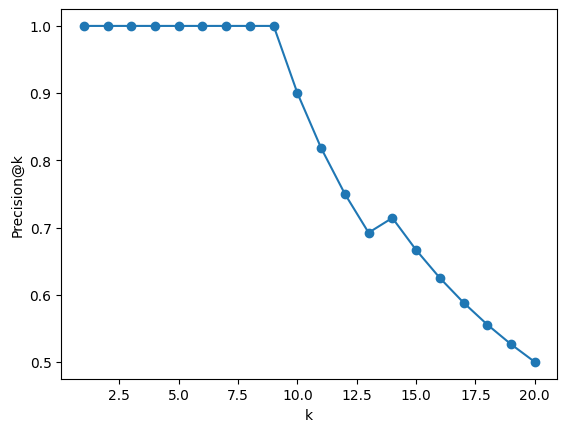

In [32]:
import random
idx = random.randint(0, ds['test'].num_rows)
ks = range(1,21)
precs = [precision_at_k(idx, split = 'test', k = k) for k in ks]
plt.plot(ks, precs, 'o-')
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.show()

We can also compute recall.

In [50]:
def recall_at_k(query_idx, split = 'test', k = 5):
    title = ds[split]['title'][query_idx] 
    query = ds[split]['question'][query_idx]
    retrieved = retriever.run(query = query, filters =  {"field": "split", "operator": "==", "value": split}, top_k = k)['documents']
    number_of_pos = sum(1 for doc in docs_clean if (list(doc.meta['title']) == title))
    tp = [list(doc.meta['title']) for doc in retrieved].count(title)
    return tp/number_of_pos

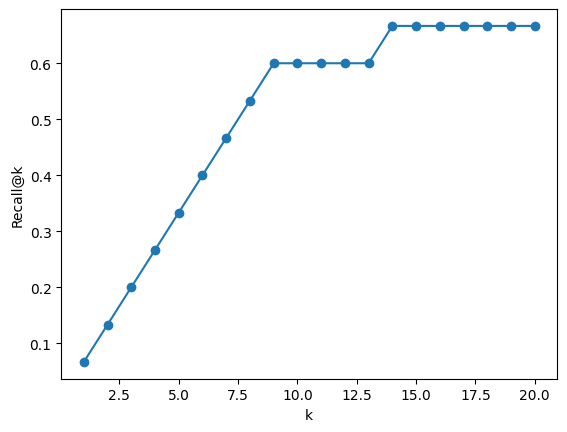

In [51]:
ks = range(1,21)
recs = [recall_at_k(idx, split = 'test', k = k) for k in ks]
plt.plot(ks, recs, 'o-')
plt.xlabel('k')
plt.ylabel('Recall@k')
plt.show()

Nice! Looks like the retriver is performing relatively well, so we will stick to BM25.

## RAG

We will build a RAG model based on these questions. Again, things don't change much from [Day 10](Day10v2.ipynb). 

In [21]:
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(model="google/flan-t5-small",
                                      task="text2text-generation",
                                      generation_kwargs={
                                        "max_new_tokens": 10,
                                        "temperature": 0.5,
                                        })

from haystack.components.builders.prompt_builder import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
100
Question: {{ query }}?
"""

In [22]:
pipe = Pipeline()

pipe.add_component("retriever", retriever)
pipe.add_component("prompt_builder", PromptBuilder(template = template))
pipe.add_component("llm", generator)

pipe.connect("retriever.documents", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceLocalGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (list[Document])
  - prompt_builder.prompt -> llm.prompt (str)

Let us give it a shot.

In [23]:
split = 'train'
idx = 0
query = ds[split]['question'][idx]
k = 10

res = pipe.run(
    {
    "prompt_builder": {
        "query": query
    },
    "retriever": {
        "filters": {"field": "split", 
                 "operator": "==", 
                 "value":  split},
        "query": query,
        "top_k": k
         },
    }
)
print('Query:', query)
print('Prediction:', res['llm']['replies'][0])
print('Expected:', ds[split]['answer'][idx])

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (7382 > 512). Running this sequence through the model will result in indexing errors
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Query: Who was the oldest British monarch at the time of ascending the throne?
Prediction: George VI
Expected: William IV


Notice that even though we chunked documenbts, some still had more than 512 tokens. This is not unexpected as the model words might break words into subwords.

In [24]:
split = 'train'
idx = 1
query = ds[split]['question'][idx]
k = 10

res = pipe.run(
    {
    "prompt_builder": {
        "query": query
    },
    "retriever": {
        "filters": {"field": "split", 
                 "operator": "==", 
                 "value":  split},
        "query": query,
        "top_k": k
         },
    }
)
print('Query:', query)
print('Prediction:', res['llm']['replies'][0])
print('Expected:', ds[split]['answer'][idx])

Query: Which river comprised the boundary between Hades and Earth in Greek mythology?
Prediction: Styx
Expected: Styx


So sometimes good, sometimes not so good. Anyway, happy implementation!